# Oze challenge example
## Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import skorch
import torch
from skorch.callbacks import EarlyStopping
from matplotlib import pyplot as plt

from time_series_predictor import TimeSeriesPredictor
from time_series_models import BenchmarkLSTM
from oze_dataset import npz_check, OzeNPZDataset

## Config

In [2]:
plot_config = {}
plot_config['training progress'] = True
plot_config['prediction on training data'] = True
plot_config['forecast'] = True

forecast_config = {}
forecast_config['include history'] = True
forecast_config['steps ahead'] = 500

predictor_config = {}
predictor_config['epochs'] = 300
predictor_config['learning rate'] = 1e-2
predictor_config['hidden dim'] = 100
predictor_config['layers num'] = 3

config = {}
config['plot'] = plot_config
config['forecast'] = forecast_config
config['predictor'] = predictor_config
config['predict on training data enabled'] = True
config['forecast enabled'] = True

## Time Series Predictor instantiation

In [3]:
tsp = TimeSeriesPredictor(
    BenchmarkLSTM(
        hidden_dim=config['predictor']['hidden dim'],
        num_layers=config['predictor']['layers num']
    ),
    early_stopping=EarlyStopping(patience=30),
    lr=config['predictor']['learning rate'],
    max_epochs=predictor_config['epochs'],
    # train_split=None, # default = skorch.dataset.CVSplit(5)
    optimizer=torch.optim.Adam
)

## Training process

In [4]:
credentials = {'user_name': os.environ.get('CHALLENGE_USER_NAME'), 'user_password': os.environ.get('CHALLENGE_USER_PASSWORD')}
ds = OzeNPZDataset(
    dataset_path=npz_check(
        Path(os.path.abspath(''), 'datasets'),
        'dataset',
        credentials=credentials
    )
)
tsp.fit(ds)

Using device cuda
Re-initializing module because the following parameters were re-set: input_dim, output_dim.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0753        0.0175  15.8466
      2        0.0160        0.0147  15.6120
      3        0.0129        0.0109  15.7320
      4        0.0096        0.0084  15.9717
      5        0.0074        0.0068  16.1543
      6        0.0063        0.0058  16.5400
      7        0.0130        0.0097  16.7927
      8        0.0075        0.0064  16.9610
      9        0.0059        0.0055  16.8000
     10        0.0051        0.0048  17.1164
     11        0.0088        0.0054  16.9106
     12        0.0048        0.0049  16.9375
     13        0.0046        0.0042  17.0290
     14        0.0040        0.0042  17.1084
     15        0.0040        0.0038  17.1097
     16        0.0037        0.0032  17.1740
     17        0.0032        0.0030  16.1340
     18 

### Plot training evolution

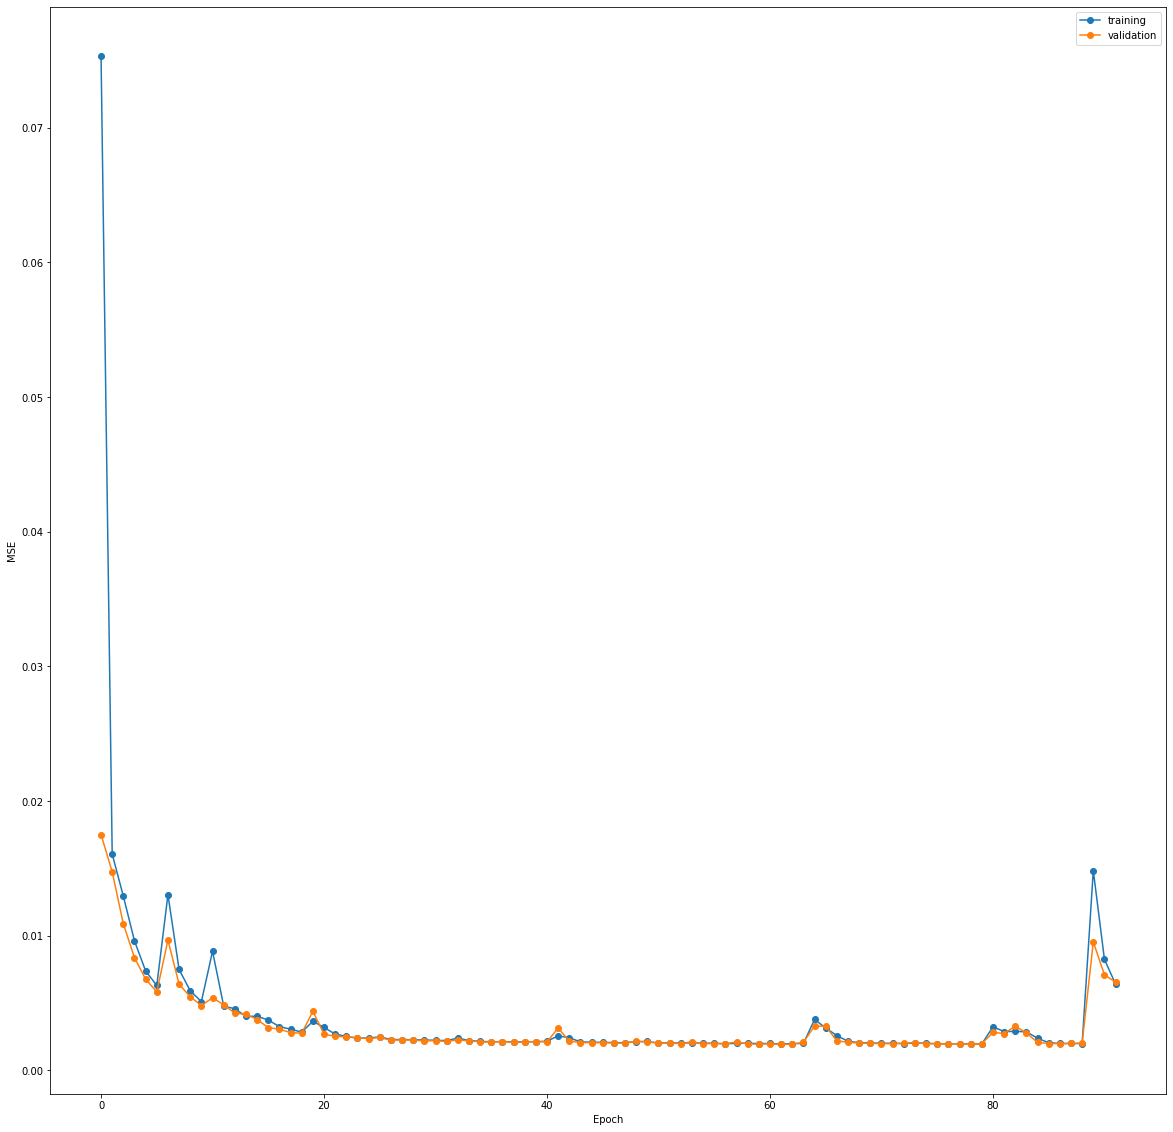

In [5]:
if config['plot']['training progress']:
    history_length = len(tsp.ttr.regressor_['regressor'].history)
    train_loss = np.zeros((history_length, 1))
    valid_loss = np.zeros((history_length, 1))
    for epoch in tsp.ttr.regressor_['regressor'].history:
        epoch_number = epoch['epoch']-1
        train_loss[epoch_number] = epoch['train_loss']
        valid_loss[epoch_number] = epoch['valid_loss']
    _, axes_one = plt.subplots(figsize=(20, 20))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    axes_one.set_xlabel('Epoch')
    axes_one.set_ylabel('MSE')
    plt.legend()

## Prediction on training data

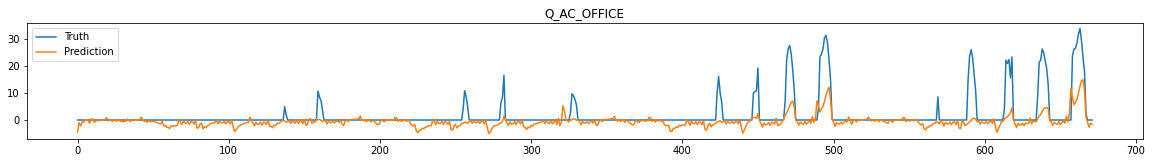

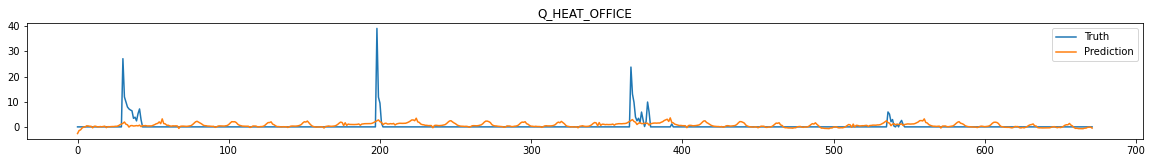

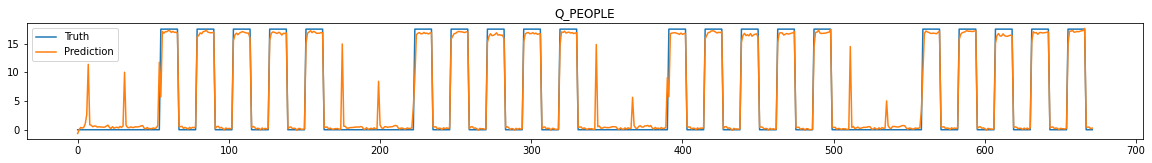

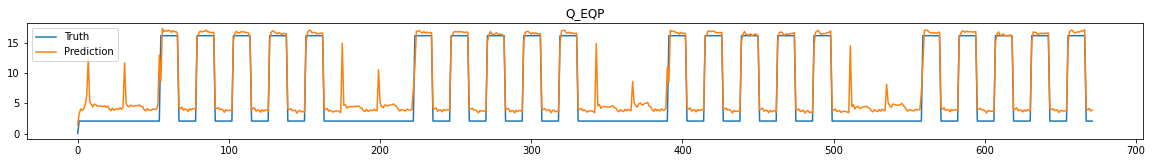

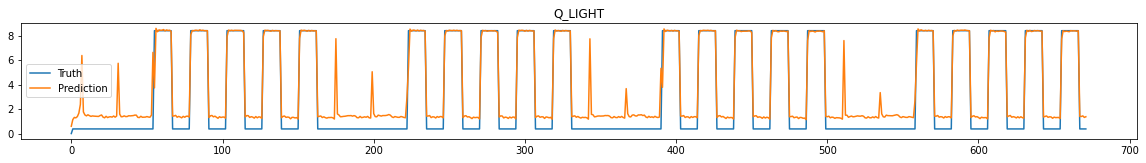

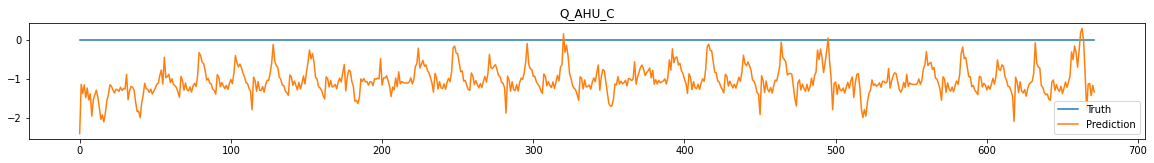

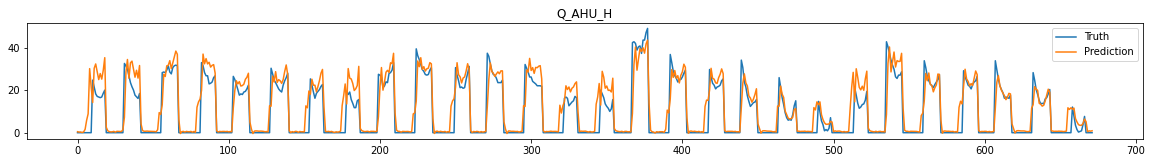

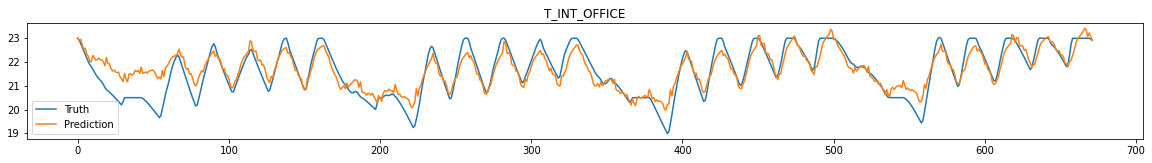

In [6]:
if config['predict on training data enabled']:
    # Select training example
    idx = np.random.randint(0, len(tsp.dataset))
    dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
    x, y = dataloader.dataset[idx]

    # Run predictions
    netout = tsp.sample_predict(x)

    d_output = netout.shape[1]
    for idx_output_var in range(d_output):
        # Select real passengers data
        y_true = y[:, idx_output_var]

        y_pred = netout[:, idx_output_var]

        if config['plot']['prediction on training data']:
            plt.figure(figsize=(20, 20))
            axes_two = plt.subplot(d_output, 1, idx_output_var+1)

            plt.plot(y_true, label="Truth")
            plt.plot(y_pred, label="Prediction")
            plt.title(tsp.dataset.labels['X'][idx_output_var])
            plt.legend()

## Future forecast

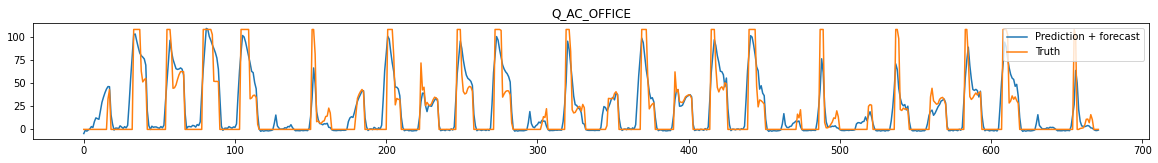

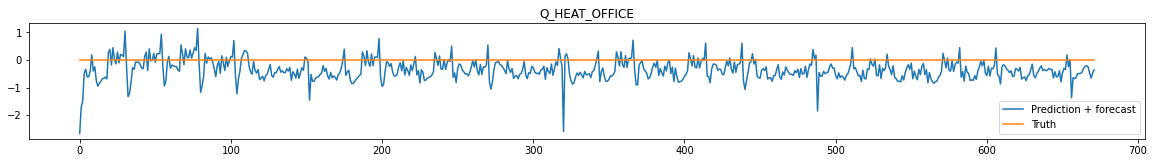

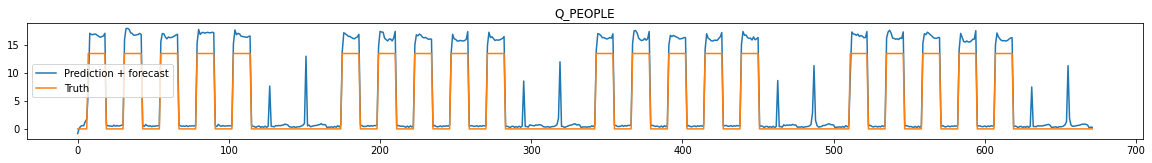

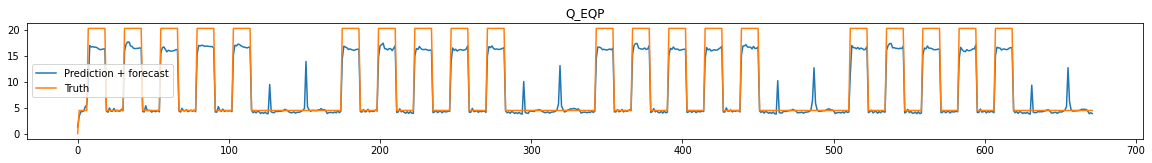

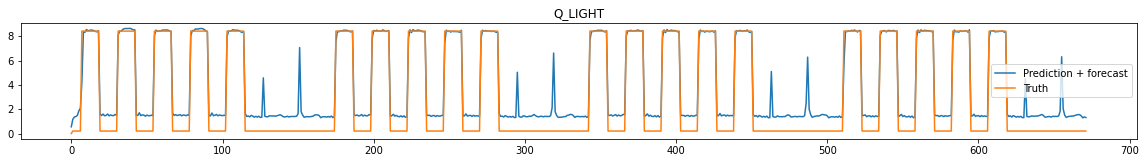

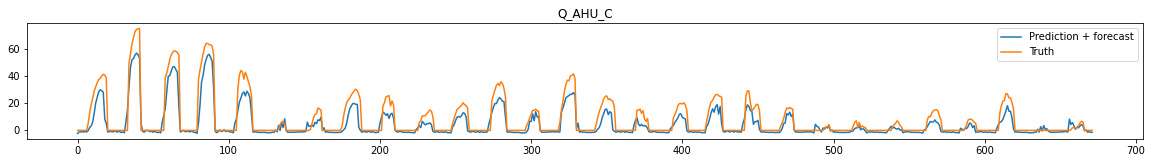

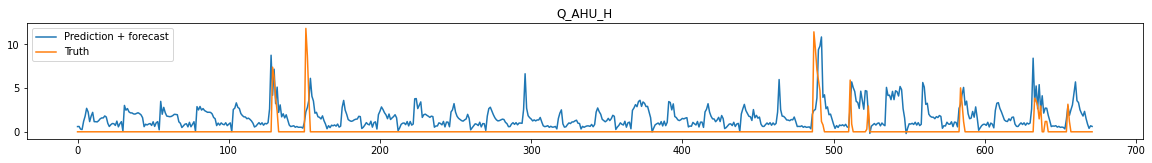

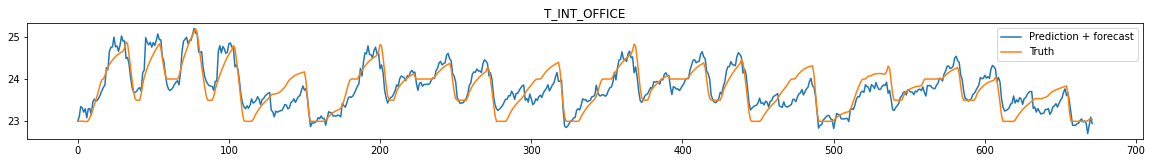

In [7]:
# Run forecast
if config['forecast enabled']:
    netout = tsp.forecast(config['forecast']['steps ahead'],
                          include_history=config['forecast']['include history'])

    d_output = netout.shape[-1]
    # Select any training example just for comparison
    idx = np.random.randint(0, config['forecast']['steps ahead'])
    dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
    x, y = dataloader.dataset[idx]
    for idx_output_var in range(d_output):
        # Select real passengers data
        y_true = y[:, idx_output_var]

        y_pred = netout[idx, :, idx_output_var]

        if config['plot']['forecast']:
            plt.figure(figsize=(20, 20))
            axes_three = plt.subplot(d_output, 1, idx_output_var+1)

            if config['forecast']['include history']:
                plot_args = [y_pred]
            else:
                y_pred_index = [i+tsp.dataset.get_x_shape()[1]+1 for i in range(len(y_pred))]
                plot_args = [y_pred_index, y_pred]
            plt.plot(*plot_args, label="Prediction + forecast")
            plt.plot(y_true, label="Truth")
            plt.title(tsp.dataset.labels['X'][idx_output_var])
            plt.legend()